In [1]:
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn
import matplotlib.pyplot as pyplot
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import pandas
import numpy
import wandb
from wandb.keras import WandbCallback

wandb.login(key='ea1404a9d16ac9056181f111599286f24c65e0e9')
wandb.init(project='covid19', entity='ashuto7h')
config = wandb.config


wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ashuto7h (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



In [2]:
# ! pip install tensorflow --upgrade


In [3]:
sdir = r'../input/large-covid19-ct-slice-dataset/curated_data/curated_data'
filepaths = []
labels = []
classlist = os.listdir(sdir)
for item in classlist:
    classpath = os.path.join(sdir, item)
    flist = os.listdir(classpath)
    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(item)

df = pandas.DataFrame()
df['filepath'] = filepaths
df['labels'] = labels
print(df['labels'].value_counts())
df = df.sample(frac=1).reset_index(drop=True)


2COVID       7593
1NonCOVID    6893
3CAP         2618
Name: labels, dtype: int64


In [4]:
df


,filepath,labels
0,../input/large-covid19-ct-slice-dataset/curate...,3CAP
1,../input/large-covid19-ct-slice-dataset/curate...,1NonCOVID
2,../input/large-covid19-ct-slice-dataset/curate...,3CAP
3,../input/large-covid19-ct-slice-dataset/curate...,2COVID
4,../input/large-covid19-ct-slice-dataset/curate...,2COVID
...,...,...
17099,../input/large-covid19-ct-slice-dataset/curate...,2COVID
17100,../input/large-covid19-ct-slice-dataset/curate...,2COVID
17101,../input/large-covid19-ct-slice-dataset/curate...,2COVID
17102,../input/large-covid19-ct-slice-dataset/curate...,1NonCOVID


In [5]:
cw = compute_class_weight('balanced', classes=df.labels.unique(), y=df.labels)
print(cw, df.labels.unique())


[2.17774382 0.8271193  0.75086703] ['3CAP' '1NonCOVID' '2COVID']


In [6]:
class_weights = {2: 2.17774382, 0: 0.8271193, 1: 0.75086703}
class_map = {'2COVID': 1, '1NonCOVID': 0, '3CAP': 2}


In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, color_mode="rgb"):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        self.color_mode = color_mode
        self.augmentor = keras.preprocessing.image.ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            brightness_range=[0, 0.2])

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) *
                           self.batch_size]
        batch = [self.indices[k] for k in index]

        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = numpy.arange(len(self.indices))
        if self.shuffle == True:
            numpy.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
        for i, id in enumerate(batch):
            img = tf.keras.preprocessing.image.load_img(
                self.df.loc[id, 'filepath'],
                color_mode=self.color_mode,
                target_size=(256, 256),
                interpolation="nearest")
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            X.append(img_array/255)
            ylist = [0, 0, 0]
            ylist[class_map[self.df.loc[id, 'labels']]] = 1
            ylist = numpy.array(ylist)
            y.append(ylist)
        X = numpy.array(X)
        X = self.augmentor.flow(
            X, batch_size=self.batch_size, shuffle=False).next()
        y = numpy.array(y)
        return X, y


In [8]:
train_data = DataGenerator(df[:13684].reset_index(drop=True))  # 80%
valid_data = DataGenerator(df[13684:15394].reset_index(drop=True))  # 80 - 90%
test_data = DataGenerator(df[15394:].reset_index(
    drop=True), shuffle=False)  # 90 - 100%

# train_data = DataGenerator(df[:200].reset_index(drop=True))  # 80%
# valid_data = DataGenerator(df[200:300].reset_index(drop=True))  # 80 - 90%
# test_data = DataGenerator(df[300:400].reset_index(drop=True), shuffle=False)  # 90 - 100%


In [9]:


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(
        filters, 3,
        activation="relu",
        padding="same")(inputs)
    x = layers.SeparableConv2D(
        filters, 3,
        activation="relu",
        padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)
    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)
    return outputs


In [10]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization


def build_model():
    inputs = layers.Input(shape=(256, 256, 3))
    x = tf.keras.applications.mobilenet.preprocess_input(inputs)
    x = MobileNet(include_top=False, weights='imagenet',
                  input_shape=(256, 256, 3))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [11]:
initial_learning_rate = 0.015
epochs = 100
model_name = "MobileNet_v3.h5"
patience = 10
decay_steps = 100000
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    model_name,
    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience,
    restore_best_weights=True)


In [12]:
config.class_weights = class_weights
config.class_map = class_map
config.initial_learning_rate = initial_learning_rate
config.epochs = epochs
config.model_name = model_name
config.patience = patience
config.decay_steps = decay_steps
config.decay_rate = decay_rate
# config.pooling = 'max'


In [13]:
model = build_model()
wandb.log({'model_summary': model.summary()})
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

history = model.fit(
    train_data,
    epochs=epochs,
    class_weight=class_weights,
    verbose=1,
    validation_data=valid_data,
    workers=2,
    callbacks=[checkpoint_cb, early_stopping_cb, WandbCallback()],
)


2021-11-13 04:54:39.992063: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 04:54:40.094623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 04:54:40.095517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 04:54:40.096867: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 256, 256, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

2021-11-13 04:54:44.139707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-13 04:54:48.612178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


427/427 [==============================] - 140s 304ms/step - loss: 0.9303 - accuracy: 0.7167 - precision: 0.7220 - recall: 0.7095 - val_loss: 2.5695 - val_accuracy: 0.3909 - val_precision: 0.3912 - val_recall: 0.3909
Epoch 2/100
427/427 [==============================] - 94s 219ms/step - loss: 0.3426 - accuracy: 0.8643 - precision: 0.8666 - recall: 0.8623 - val_loss: 8.0189 - val_accuracy: 0.1539 - val_precision: 0.1539 - val_recall: 0.1539
Epoch 3/100
427/427 [==============================] - 96s 223ms/step - loss: 0.2104 - accuracy: 0.9109 - precision: 0.9128 - recall: 0.9094 - val_loss: 1.8870 - val_accuracy: 0.4581 - val_precision: 0.4584 - val_recall: 0.4581
Epoch 4/100
427/427 [==============================] - 95s 222ms/step - loss: 0.1735 - accuracy: 0.9284 - precision: 0.9297 - recall: 0.9275 - val_loss: 8.4437 - val_accuracy: 0.4617 - val_precision: 0.4617 - val_recall: 0.4617
Epoch 5/100
427/427 [==============================] - 94s 220ms/step - loss: 0.1325 - accuracy: 0.

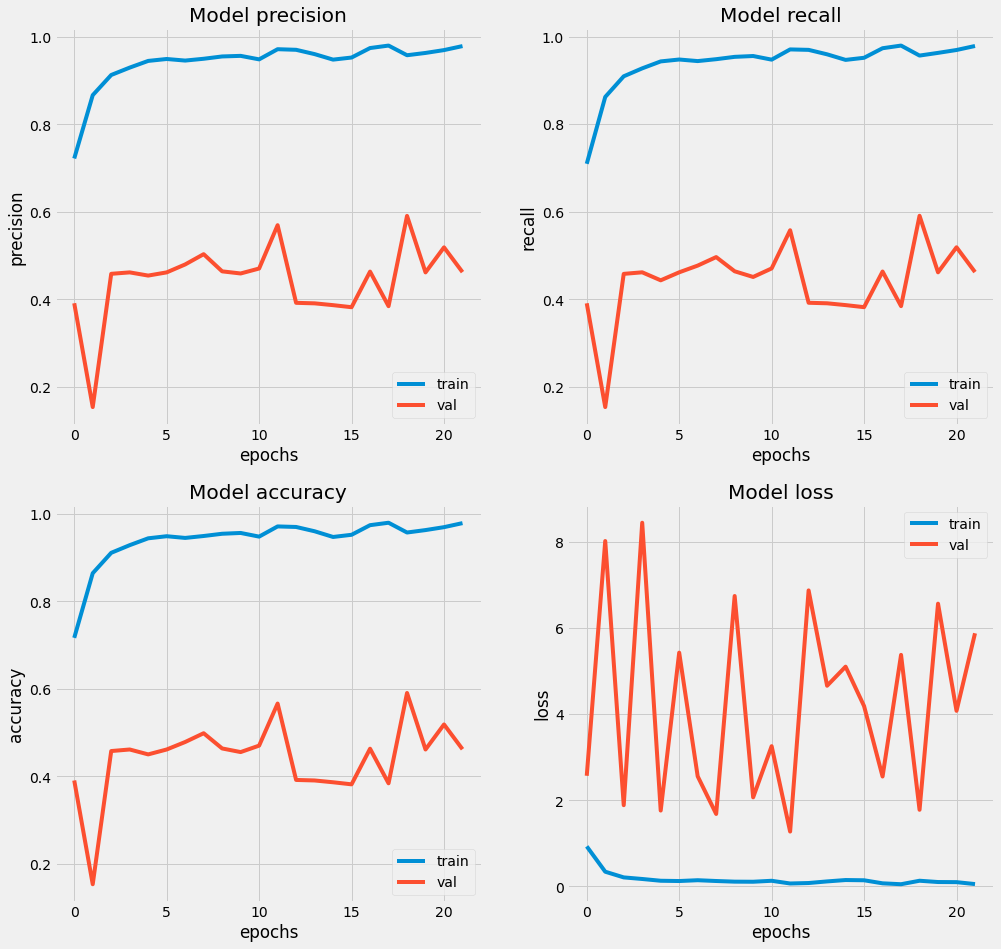

In [14]:
pyplot.style.use('fivethirtyeight')
fig, ax = pyplot.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])
try:
    wandb.log({'training log img': wandb.Image(fig)})
except:
    pass


In [15]:
train_eval = model.evaluate(train_data, return_dict=True)
wandb.log({'train evaluation': train_eval})
display('train evaluation', train_eval)

valid_eval = model.evaluate(valid_data, return_dict=True)
wandb.log({'valid evaluation': valid_eval})
display('valid evaluation', valid_eval)

test_eval = model.evaluate(test_data, return_dict=True)
wandb.log({'test evaluation': test_eval})
display('test evaluation', test_eval)


427/427 [==============================] - 86s 202ms/step - loss: 1.2761 - accuracy: 0.5714 - precision: 0.5737 - recall: 0.5615


'train evaluation'

{'loss': 1.2761154174804688,
 'accuracy': 0.5714285969734192,
 'precision': 0.5736822485923767,
 'recall': 0.5615485906600952}

53/53 [==============================] - 13s 237ms/step - loss: 1.2744 - accuracy: 0.5672 - precision: 0.5701 - recall: 0.5584


'valid evaluation'

{'loss': 1.274399757385254,
 'accuracy': 0.5672169923782349,
 'precision': 0.5701384544372559,
 'recall': 0.5583726167678833}

53/53 [==============================] - 23s 434ms/step - loss: 1.2892 - accuracy: 0.5825 - precision: 0.5856 - recall: 0.5767


'test evaluation'

{'loss': 1.2891693115234375,
 'accuracy': 0.5825471878051758,
 'precision': 0.5856287479400635,
 'recall': 0.5766509175300598}

In [16]:
def get_class(value):
    for key in class_map.keys():
        if class_map[key] == value:
            return key


get_class(2)


'3CAP'

### Confusion matrix - validation


53/53 [==============================] - 11s 192ms/step
              precision    recall  f1-score   support

           0       0.51      0.78      0.61       652
           1       0.66      0.58      0.62       785
           2       0.00      0.00      0.00       259

    accuracy                           0.57      1696
   macro avg       0.39      0.45      0.41      1696
weighted avg       0.50      0.57      0.52      1696



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

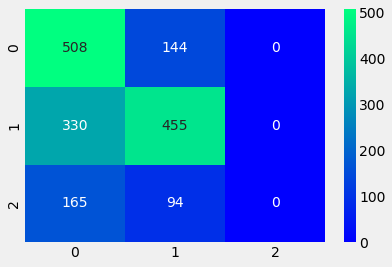

In [17]:
labels = []
for image, label in valid_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(valid_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix valid img': wandb.Image(x)})
except:
    pass
display(x)


In [18]:

labels = []
for image, label in test_data:
    labels.append(label)

labels = numpy.array(labels).reshape(-1, 3)
predictions = model.predict(test_data, verbose=1)
labels = numpy.argmax(labels, axis=-1)
y_pred = numpy.argmax(predictions, axis=-1)

# get the classification report
cr = classification_report(labels, y_pred)
print(cr)


53/53 [==============================] - 11s 202ms/step
              precision    recall  f1-score   support

           0       0.53      0.81      0.64       680
           1       0.67      0.58      0.62       747
           2       0.00      0.00      0.00       269

    accuracy                           0.58      1696
   macro avg       0.40      0.47      0.42      1696
weighted avg       0.51      0.58      0.53      1696



<AxesSubplot:>

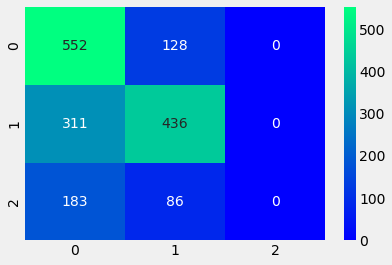

In [19]:
cm = confusion_matrix(labels, y_pred)
x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
try:
    wandb.log({'confusion matrix test img': wandb.Image(x)})
except:
    pass
display(x)
